In [1]:
from joblib import Parallel, delayed 
import matplotlib.pyplot as plt
from skimage import transform
from scipy.io import loadmat
from scipy import ndimage
from scipy import signal
import numpy as np
import argparse
import time
import h5py
import math
import sys
import os

In [16]:
def readDCA1000_1642(fileName):
  # global variables
  #change based on sensor config
  numADCSamples = 256; # number of ADC samples per chirp
  numADCBits = 16; # number of ADC bits per sample
  numRX = 4; # number of receivers
  numLanes = 2; # do not change. number of lanes is always 2
  isReal = 0; # set to 1 if real only data, 0 if complex data0

  # read .bin file
  with open(fileName, "rb") as fid:
      adcData = np.array(np.frombuffer(fid.read(), dtype=np.int16))
      
  # if 12 or 14 bits ADC per sample compensate for sign extension
  if numADCBits != 16:
      l_max = 2**(numADCBits-1)-1
      adcData[adcData > l_max] -= 2**numADCBits

  fileSize = adcData.shape[0]
  
  # real data reshape, filesize = numADCSamples*numChirps
  if isReal:
    numChirps = int(fileSize/numADCSamples/numRX)
    #create column for each chirp
    LVDS = np.reshape(adcData, (numADCSamples*numRX, numChirps), order='F').transpose()
  else:
    # for complex data
    # filesize = 2 * numADCSamples*numChirps
    numChirps = int(fileSize/2/numADCSamples/numRX)
    LVDS = np.zeros(int(fileSize/2)).astype(np.complex)
    # combine real and imaginary part into complex data
    # read in file: 2I is followed by 2Q
    LVDS[::2]  = adcData[::4]  + np.complex(0,1)*adcData[2::4]
    LVDS[1::2] = adcData[1::4] + np.complex(0,1)*adcData[3::4]
    # create column for each chirp
    # each row is data from one chirp
    LVDS = np.reshape(LVDS, (numADCSamples*numRX, numChirps), order='F').transpose()

  # organize data per RX
  adcData = np.zeros((numRX,numChirps*numADCSamples)).astype(np.complex)
  for row in range(numRX):
      for i in range(numChirps):
        adcData[row, i*numADCSamples:((i+1)*numADCSamples)] = LVDS[i, row*numADCSamples:((row+1)*numADCSamples)]
        
  return adcData

def read_samples(dataset_path, endswith=".bin", num_keep=100):
  datapaths, labels = list(), list()
  classes = sorted([f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f)) and not f.startswith('.')])

  for c in classes:
    c_dir = os.path.join(dataset_path, c)
    dates = sorted(os.listdir(c_dir))
    for date in dates:
      samples = os.listdir(os.path.join(c_dir, date))
      for sample in samples:
        if sample.endswith(endswith):
          datapaths.append(os.path.join(c_dir, date, sample))
          labels.append([classes.index(c), dates.index(date)])
  return datapaths, labels, classes

def fspecial_gaussian(size=15, sigma=2):
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    kernel /= np.sum(kernel)
    return kernel

def smooth(x,window_len):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    w=np.hanning(window_len)
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2):-(window_len//2)]

def cfar(x, num_train, num_guard, rate_fa):
    num_cells = x.size
    num_train_half = round(num_train / 2)
    num_guard_half = round(num_guard / 2)
    num_side = num_train_half + num_guard_half
 
    alpha = num_train*(rate_fa**(-1/num_train) - 1)
    
    peak_idx = []
    for i in range(num_side, num_cells - num_side):
        
        if i != i-num_side+np.argmax(x[i-num_side:i+num_side+1]): 
            continue
        
        sum1 = np.sum(x[i-num_side:i+num_side+1])
        sum2 = np.sum(x[i-num_guard_half:i+num_guard_half+1]) 
        p_noise = (sum1 - sum2) / num_train 
        threshold = alpha * p_noise
        
        if x[i] > threshold: 
            peak_idx.append(i)
    
    peak_idx = np.array(peak_idx, dtype=int)
    
    return peak_idx

def detect_peak(data):
    data = np.abs(data[250:])

    for _ in range(6):
        data -= np.mean(data)
        data[np.where(data < 0)] = 0
    data = smooth(data, 2001)
    
    if(np.var(data) < 5000):
        return False, [] 
    
    peak_idx = cfar(data, num_train=100, num_guard=25, rate_fa=1)
    
    k_inds = peak_idx[np.where(data[peak_idx] > (np.max(data)/3))]
    k_inds.sort()
    k_inds+=250
    
    if (len(k_inds) > 0):
        return True, k_inds
    else:
        return False, []


def get_spectrogram(fname, label, mat_file=False):
    if mat_file:
      iq_data = loadmat(fname)["iq_data"]
    else:
      iq_data = readDCA1000_1642(fname)
    
    data = iq_data[0,:].reshape((-1, num_frame), order="F")

    tmp = []
    for j in range(num_frame):
        tmp.append(data[:, j].reshape((num_adc, num_chirp), order="F"))
    data = np.hstack(tmp)
    
    data = (data.transpose()*signal.hann(num_adc)).transpose()
    range_matrix = np.fft.fft(data, axis=0)
        
    b, a = signal.butter(8, 50/(fs/2), 'high')
    start = False
    frame_slices = []
    start_id = range_min
    end_id = range_max
    direc = None
    for j in range(range_min, range_max):
        range_matrix[j, :] = signal.lfilter(b, a, range_matrix[j,:], axis=0)    

        tmp_status, peak_ids = detect_peak(range_matrix[j, :])
        
        if (start and not tmp_status):
            end_id = j
            break
        elif tmp_status and not start:
            start = True
            start_id = j
            if (peak_ids[-1] > range_matrix[j, :].shape[-1]/2):
                direc = 0
            else:
                direc = -1
            init_window = peak_ids[direc]
            frame_slices.append(init_window)
                        
            range_matrix[j, :init_window-attention_window_length] = 0
            range_matrix[j, init_window+attention_window_length:] = 0
        elif start:            
            if (direc == 0):
                init_window = peak_ids[np.where(np.logical_and(peak_ids >= init_window-5*attention_window_length, peak_ids <= (init_window+3*attention_window_length)))]
            else:
                init_window = peak_ids[np.where(np.logical_and(peak_ids <= init_window+5*attention_window_length, peak_ids >= (init_window-3*attention_window_length)))]         
            
            if len(init_window) == 0:
                end_id = j
                break
                
            init_window = init_window[direc]
            frame_slices.append(init_window)
            
            range_matrix[j, :init_window-attention_window_length] = 0
            range_matrix[j, init_window+attention_window_length:] = 0
            
    if(len(frame_slices) < 1):
        return np.array([]), label

    range_matrix = range_matrix[start_id:end_id]    
    
    for j in range(range_matrix.shape[0]):
        f_vec, t, S = signal.spectrogram(range_matrix[j,:], 
                                        fs=fs, 
                                        window=spec_window,
                                        noverlap=noverlap, 
                                        nfft=nfft,
                                        return_onesided=False,
                                        mode="complex")
        
        if (j == 0):
            S_new_all = np.abs(S)
        else:
            S_new_all += np.abs(S)
            
    S_new_all = np.roll(S_new_all, int(S_new_all.shape[0]/2), axis=0)
    
    sums = np.sum(S_new_all, 0)
    sum_inds = np.where(sums == 0)[0]
    sums[sum_inds] = 1
    fix_arr = np.ones_like(sums)
    fix_arr[sum_inds] = 0

    S_new_all /= sums
    S_new_all *= fix_arr
    S_new_all -= np.mean(S_new_all)
    S_new_all[np.where(S_new_all < 0)] = 0

    S_new_all = ndimage.convolve(S_new_all, fspecial_gaussian(), mode='nearest')
    S_new_all[np.where(S_new_all <= 0)] = 1e-9
    S_new_all = 20*np.log10(S_new_all)

    '''
    if direc == 0:
        S_new_all = S_new_all[128:int(S_new_all.shape[0]/2), int((min(frame_slices)-attention_window_length)/16):int((max(frame_slices)+attention_window_length)/16)]
        S_new_all = S_new_all[:, int(S_new_all.shape[1]/2)-512:int(S_new_all.shape[1]/2)+512]
    elif direc == -1:
        S_new_all = S_new_all[int(S_new_all.shape[0]/2):-128, int((min(frame_slices)-attention_window_length)/16):int((max(frame_slices)+attention_window_length)/16)]
        S_new_all = S_new_all[:, int(S_new_all.shape[1]/2)-512:int(S_new_all.shape[1]/2)+512]      
        S_new_all = np.flip(S_new_all, axis=0)
        S_new_all = np.flip(S_new_all, axis=1)
        
    if (S_new_all.shape != (128, 1024)):
        return np.array([]), label
    '''
    return S_new_all, label  

In [17]:
def get_spectrogram_debug(fname, label, mat_file=False):
    
    w = 10
    
    if mat_file:
      iq_data = loadmat(fname)["iq_data"]
    else:
      iq_data = readDCA1000_1642(fname)
    
    data = iq_data[0,:].reshape((-1, num_frame), order="F")
    
    tmp = []
    for j in range(num_frame):
        tmp.append(data[:, j].reshape((num_adc, num_chirp), order="F"))
    data = np.hstack(tmp)

    data = (data.transpose()*signal.hann(num_adc)).transpose()
    range_matrix = np.fft.fft(data, axis=0)
        
    b, a = signal.butter(8, 50/(fs/2), 'high')
    start = False
    for j in range(range_min, range_max):

        range_matrix[j, :] = signal.lfilter(b, a, range_matrix[j,:], axis=0)    
        tmp_status, peak_ids = detect_peak(range_matrix[j, :])
            
        if (start and not tmp_status):
            print(j)
            continue
        elif tmp_status and not start:
            start = True
            if (peak_ids[-1] > range_matrix[j, :].shape[-1]/2):
                direc = 0
            else:
                direc = -1
            init_window = peak_ids[direc]
            
            plt.plot(np.abs(range_matrix[j, :]), alpha=0.4)
            plt.axvline(x=init_window, color='C2')        
            plt.show()

        elif start:
            plt.plot(np.abs(range_matrix[j, :]), alpha=0.4)
            
            if (direc == 0):               
                print("D1 - peak_ids:", peak_ids);
                init_window = peak_ids[np.where(np.logical_and(peak_ids >= init_window-5*attention_window_length, peak_ids <= (init_window+5*attention_window_length)))]
            else:
                print("D2 - peak_ids:", peak_ids);
                init_window = peak_ids[np.where(np.logical_and(peak_ids <= init_window+5*attention_window_length, peak_ids >= (init_window-5*attention_window_length)))]         
            if len(init_window) == 0:
                print(j)
                continue
            init_window = init_window[direc]
            
            if (direc == 0):
                plt.axvline(x=init_window-5*attention_window_length, color='C1')
                plt.axvline(x=init_window+5*attention_window_length, color='C1')
            else:
                plt.axvline(x=init_window-5*attention_window_length, color='C1')
                plt.axvline(x=init_window+5*attention_window_length, color='C1')

            plt.axvline(x=init_window, color='C2')        
            plt.show() 


In [18]:
c = 3e8
max_range = 5
min_range = 1
band_width = 900.9*1e6
range_res = c/(2*band_width)
range_min = int(np.ceil(min_range/range_res))-1
range_max = int(np.ceil(max_range/range_res))-1

num_frame = 200
num_adc = 256
frame_period = 33*1e-3
num_chirp = 230
fs = 1/(frame_period/num_chirp)
chirp_duration = frame_period/num_chirp

nfft = 512
noverlap = nfft - 16
spec_window = signal.windows.chebwin(nfft, 120)
attention_window_length = int(np.ceil(0.2/chirp_duration))

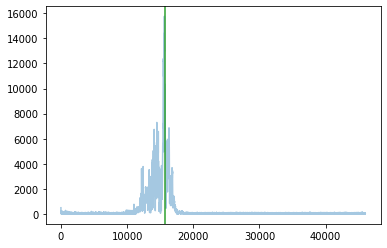

D2 - peak_ids: [16622]


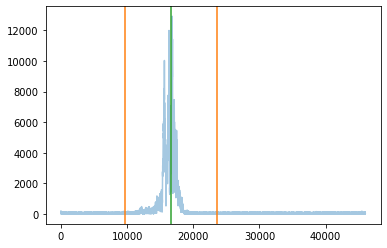

D2 - peak_ids: [17255]


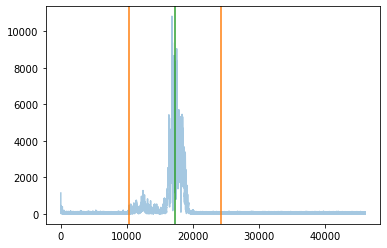

D2 - peak_ids: [18515]


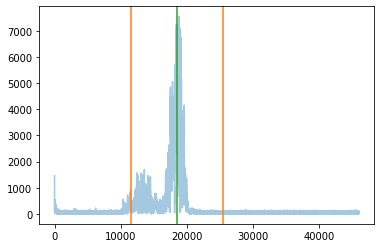

D2 - peak_ids: [19478]


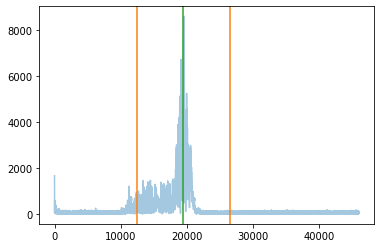

D2 - peak_ids: [20629]


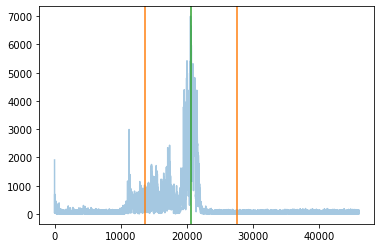

D2 - peak_ids: [21440]


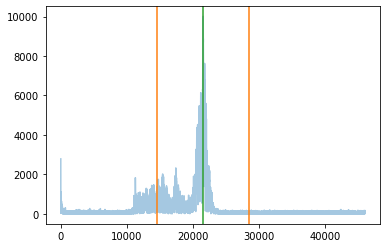

D2 - peak_ids: [21864]


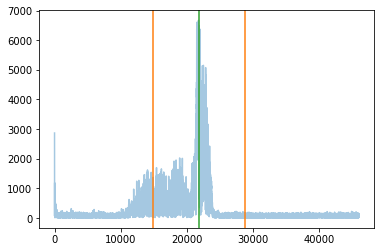

D2 - peak_ids: [18943 23408]


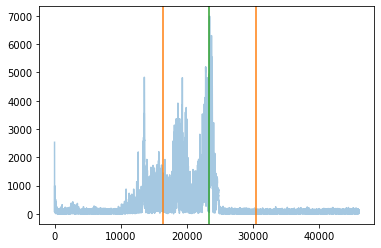

D2 - peak_ids: [19715 23863]


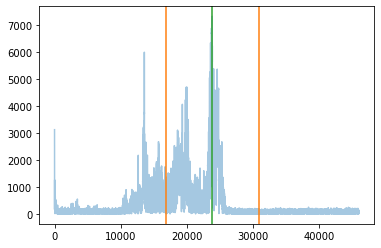

D2 - peak_ids: [25005]


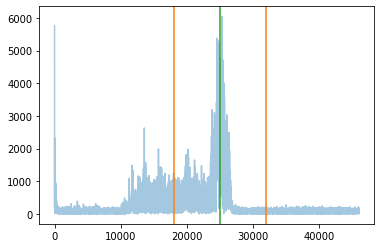

D2 - peak_ids: [26366]


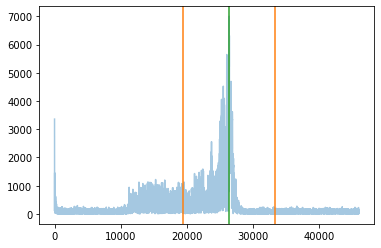

D2 - peak_ids: [26794]


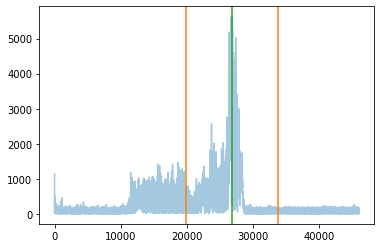

D2 - peak_ids: [28000]


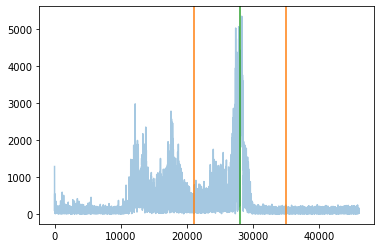

D2 - peak_ids: [13663 17312 28897]


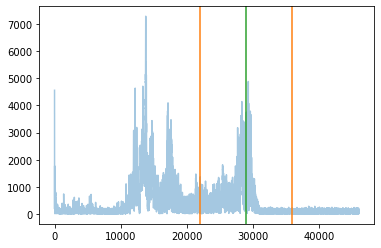

D2 - peak_ids: [15135]
21
D2 - peak_ids: [15966 30951]


ValueError: operands could not be broadcast together with shapes (2,) (0,) 

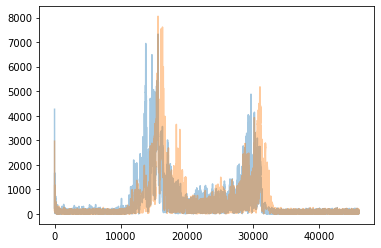

In [19]:
data = get_spectrogram_debug("/home/pjanakar/09_24_08.bin", 0)

(512, 2844)


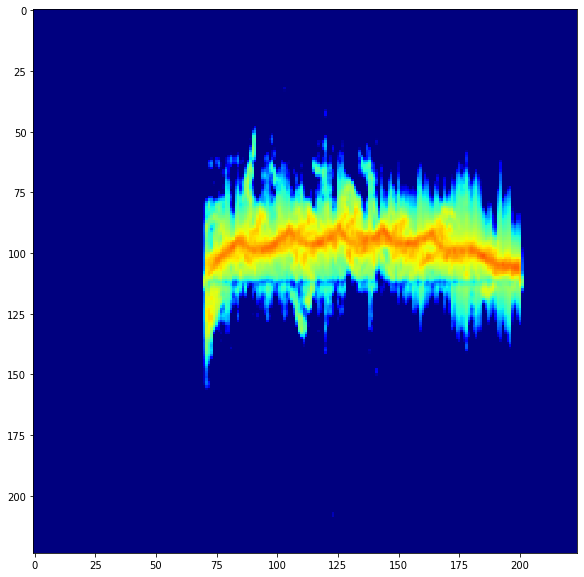

In [95]:
data = get_spectrogram("/home/pjanakar/Documents/MATLAB/champ_server/14_29_02.bin", 0)
print(data[0].shape)
data = transform.resize(data[0], (224, 224), mode='reflect', anti_aliasing=True)
cmap_obj = plt.cm.ScalarMappable(cmap="jet")
cmap_obj.set_clim(-120, 0)
plt.figure(figsize=(10,10))
plt.imshow(cmap_obj.to_rgba(data)[:, :, :3])

In [91]:
data = get_spectrogram("/mnt/archive2/target/server/ppinyoan/06_21/14_20_57.bin", 0)
print(data[0].shape)
data = transform.resize(data[0], (224, 224), mode='reflect', anti_aliasing=True)
cmap_obj = plt.cm.ScalarMappable(cmap="jet")
cmap_obj.set_clim(-120, 0)
plt.figure(figsize=(10,10))
plt.imshow(cmap_obj.to_rgba(data)[:, :, :3])

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/archive2/target/server/ppinyoan/06_21/14_20_57.bin'

In [ ]:
dataset_file = "/home/kjakkala/mmwave/data/mmwave_target_server.h5"
src_path = "/mnt/archive2/target/server"

files, labels, classes = read_samples(src_path, ".bin")
classes = [n.encode("ascii", "ignore") for n in classes]

dset_X, dset_y = zip(*Parallel(n_jobs=-1)(delayed(get_spectrogram)(files[i], labels[i]) for i in range(len(files))))
dset_X = np.array(dset_X)
dset_y = np.array(dset_y)
print(dset_y.shape, dset_X.shape)

delete_inds = []
for ind in range(len(dset_X)):
    if (dset_X[ind].shape != (128, 1024)):
        delete_inds.append(ind)
        print(files[ind])
        
print(len(delete_inds))

dset_X = np.delete(dset_X, delete_inds, 0)
dset_X = np.array(list(dset_X))
dset_y = np.delete(dset_y, delete_inds, 0)
dset_y = np.array(list(dset_y))
print(dset_y.shape, dset_X.shape)

In [ ]:
hf = h5py.File("/home/kjakkala/mmwave/data/target_server_data.h5", 'w')
hf.create_dataset('X_data', data=dset_X)
hf.create_dataset('y_data', data=dset_y)
hf.create_dataset('classes', data=classes)
hf.close()